In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer

import gensim, logging, warnings
import gensim.corpora as corpora
from gensim import corpora, models
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [4]:
lemmatizer = WordNetLemmatizer()

In [5]:
stop_words.extend(['look', 'smell', 'taste', 'feel', 'overall', 'rdev', 'beer', 'beers','nice','adams', 'jan', 'feb', 'mar',
                  'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'ml', 'oz', 'date'])

In [12]:
def to_string(list_):
    return " ".join(list_)

In [20]:
def clean_review(review):
    """takes in a review and does the following:
    1. removes the '\xa0'
    2. removes the '\n'
    3. performs the simple preprocess from gensim"""
    review = review.replace(u'\\xa0', '')
    review = review.replace('\\n', '')
    review = re.sub(r'(characters){1}\S*', '', review)
    review = gensim.utils.simple_preprocess(str(review), deacc=True)
    review = [word for word in review if word not in stop_words]
    meta_lemmed = [lemmatizer.lemmatize(word, pos='v') for word in review]
#     c = " ".join(str(x) for x in meta_lemmed)
#     cleaned.append(c)
    return meta_lemmed

In [63]:
# change ABV to float
df['abv'] = df['abv'].str.replace('%', '')
df['abv'] = df['abv'].astype(float)

In [6]:
df = pd.read_csv('mvp_df.csv', index_col=0)

In [67]:
df.loc[df['abv'] == 100]['url']

12705     https://www.beeradvocate.com/beer/profile/2591...
140945    https://www.beeradvocate.com/beer/profile/4238...
Name: url, dtype: object

In [70]:
df.loc[140945, 'url']

'https://www.beeradvocate.com/beer/profile/42389/418950/'

In [90]:
df['clean_review'] = df['review'].apply(clean_review)

In [91]:
df['key_words'] = df['clean_review'].apply(to_string)

In [1]:
df.head()

NameError: name 'df' is not defined

In [86]:
df.columns

Index(['abv', 'avail', 'avg_score', 'ba_score', 'brewery', 'img', 'location',
       'name', 'no_ratings', 'no_reviews', 'review', 'style', 'url',
       'taste_avg', 'look_avg', 'smell_avg', 'feel_avg', 'clean_review',
       'key_words'],
      dtype='object')

In [93]:
df.drop(['abv', 'avail', 'avg_score', 'ba_score', 'brewery', 'img', 'location',
         'no_ratings', 'no_reviews', 'review', 'style', 'url',
       'taste_avg', 'look_avg', 'smell_avg', 'feel_avg', 'clean_review'], inplace=True, axis=1)

In [33]:
df.drop(['clean_review'], axis=1, inplace=True)

In [94]:
df.set_index(['name'], inplace=True, drop=True)

In [38]:
"Shiner Bock"

'Shiner Bock'

In [173]:
df.sample(20)

,key_words
name,
ScuttleBrau (2019),pour teku pour clean clear reddish brown color...
UrBock,bottle pour light golden amber small head slow...
Ashford,hook norton fest gravity feed dark chestnut co...
Double Dunkel,never hear wibby brew kick find bohemian bierg...
Mystery,muddy brown color beige head aroma burn coffee...
Klitnisse,boxbeers abv bavaria hefe glass watch belle hu...
Suburb - Citra,serve pint glass date gift mr jj pour moderate...
Shadowplay,canvery dark almost black hold light get tan c...
Hop-O-Matic,color dark orange sticky headthe endear sheer ...


# Putting this aside for now

In [29]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words=stop_words)
tfidf_matrix = tf.fit_transform(df['key_words'])

In [30]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

# Skip to here

In [39]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(df['key_words'])

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [106]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words=stop_words)
tfidf_matrix = tf.fit_transform(df['key_words'])

In [107]:
tf_cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [40]:
cosine_sim

array([[1.        , 0.57243905, 0.49726859, ..., 0.4337387 , 0.41315144,
        0.50843727],
       [0.57243905, 1.        , 0.53924372, ..., 0.4046681 , 0.3588685 ,
        0.47653144],
       [0.49726859, 0.53924372, 1.        , ..., 0.3474918 , 0.34840618,
        0.39846679],
       ...,
       [0.4337387 , 0.4046681 , 0.3474918 , ..., 1.        , 0.37905668,
        0.52604679],
       [0.41315144, 0.3588685 , 0.34840618, ..., 0.37905668, 1.        ,
        0.55420416],
       [0.50843727, 0.47653144, 0.39846679, ..., 0.52604679, 0.55420416,
        1.        ]])

In [175]:
# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use in the function to match the indexes
indices = pd.Series(df.index)

#  defining the function that takes in beer name 
# as input and returns the top 10 recommended beers
def recommendations(cosine_sim = cosine_sim):
    title = input('What beer do you like?')
    # initializing the empty list of recommended beers
    recommended_beers = []
    
    # gettin the index of the beer that matches the name
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching beers
    for i in top_10_indexes:
        recommended_beers.append(list(df.index)[i])
        
    return recommended_beers

In [176]:
recommendations()

What beer do you like?Double Dunkel


["Market Street D'Artagnan Dark British Ale",
 'Dockside Amber Lager',
 'Hops Alligator Ale',
 "Young's Winter Warmer",
 'Cara De Luna Black Ale',
 'Blackwatch',
 'Dark Lager',
 'Haunted House',
 'Franconia Dunkel',
 'Atwater Dunkel']

In [174]:
recommendations(title="Double Dunkel")

["Market Street D'Artagnan Dark British Ale",
 'Dockside Amber Lager',
 'Hops Alligator Ale',
 "Young's Winter Warmer",
 'Cara De Luna Black Ale',
 'Blackwatch',
 'Dark Lager',
 'Haunted House',
 'Franconia Dunkel',
 'Atwater Dunkel']

In [108]:
recommendations(title="Patchwork Kilt", cosine_sim=tf_cosine_sim)

["Gritty McDuff's Scottish Ale",
 "Maxwell's Scottish Ale",
 'Granola Brown Ale',
 'Attic & Eaves Toasted Brown Ale',
 'Black Douglas Ale',
 "Henry's Farm Double Bock",
 'Laughing Lab Scottish-Style Ale',
 'Hooligan Nut Brown',
 'Cains Dark Mild',
 "Short's Bellaire Brown Ale"]

# I want to try topic modeling again

In [123]:
df2 = pd.read_csv('mvp_df.csv', index_col=0)

In [113]:
df2.columns

Index(['abv', 'avail', 'avg_score', 'ba_score', 'brewery', 'img', 'location',
       'name', 'no_ratings', 'no_reviews', 'review', 'style', 'url',
       'taste_avg', 'look_avg', 'smell_avg', 'feel_avg', 'clean_review'],
      dtype='object')

In [124]:
df_sm = df2.drop(['abv', 'avail', 'avg_score', 'ba_score', 'brewery', 'img', 'location',
       'no_ratings', 'no_reviews', 'review', 'style', 'url',
       'taste_avg', 'look_avg', 'smell_avg', 'feel_avg'], axis=1)

In [117]:
df2.head()

,name,clean_review
0,Samuel Adams Winter Lager,"['alright', 'one', 'depend', 'great', 'deep', ..."
1,Shiner Bock,"['first', 'sample', 'visit', 'father', 'texas'..."
2,Samuel Adams Chocolate Bock,"['black', 'color', 'little', 'light', 'penetra..."
3,Michelob AmberBock,"['bottle', 'abv', 'purchase', 'cold', 'single'..."
4,Samuel Adams Cherry Chocolate Bock,"['initial', 'whiff', 'dr', 'pepper', 'cherry',..."


In [122]:
df2.shape

(20293, 2)

In [120]:
# Create Dictionary
id2word = corpora.Dictionary(df2['clean_review'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df2['clean_review']]

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

# Data Viz

In [126]:
df2.describe()

,abv,avg_score,ba_score,no_ratings,no_reviews,taste_avg,look_avg,smell_avg,feel_avg
count,18944.000000,20293.000000,8684.000000,20293.000000,20293.000000,20199.00000,20199.000000,20199.000000,20199.000000
mean,6.293755,3.724887,84.882427,99.452422,29.175873,3.73379,3.820671,3.691264,3.691264
std,1.547638,0.366695,4.048835,532.948571,147.852177,0.46149,0.387637,0.431890,0.431890
min,2.000000,1.030000,63.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000
25%,5.200000,3.550000,83.000000,2.000000,1.000000,3.50000,3.638889,3.500000,3.500000
50%,6.100000,3.760000,85.000000,6.000000,2.000000,3.75000,3.875000,3.750000,3.750000
75%,7.000000,3.950000,87.000000,35.000000,10.000000,4.00000,4.000000,4.000000,4.000000
max,57.500000,5.000000,100.000000,16192.000000,4017.000000,5.00000,5.000000,5.000000,5.000000


In [162]:
f, ax = plt.subplots(figsize=(12,8))
ax = sns.scatterplot(x='name', y='taste_avg', data=df2)
ax.set_title("Distribution of ABV")
ax.set_xlabel("ABV");

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1a201d5048> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1a204dbbf8> (for post_execute):


KeyboardInterrupt: 

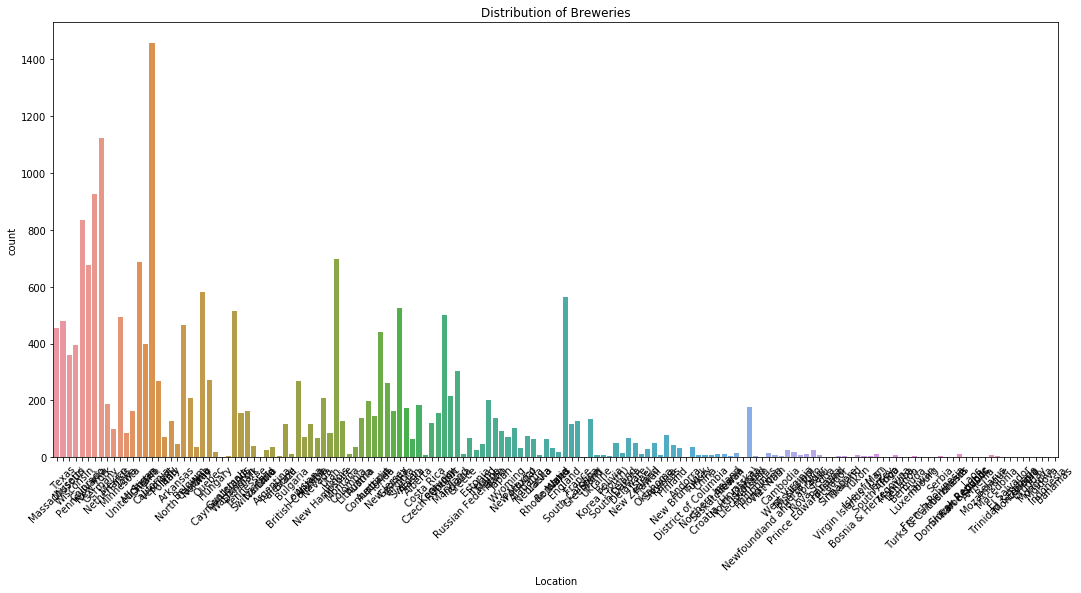

In [168]:
f, ax = plt.subplots(figsize=(18,8))
ax = sns.countplot(x='location', data=df2)
ax.set_title("Distribution of Breweries")
plt.xticks(rotation=45)
ax.set_xlabel("Location");

In [170]:
states = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont','New York', 'New Jersey', 'Pennsylvania','Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota','Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia','West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas',
             'Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']

In [172]:
df['world_location'] = ['us' for x in df['location'] if x in states else x]

SyntaxError: invalid syntax (<ipython-input-172-5ef5bb88a5fa>, line 1)

In [171]:
df['world_location'] = [x for x in df['location'] if x not in states else 'us']

SyntaxError: invalid syntax (<ipython-input-171-de85f79857ee>, line 1)